In [1]:
import numpy as np
import torch as t
import torch.nn.functional as F
import os
import os.path
import itertools

from tqdm.autonotebook import tqdm
from time import gmtime, strftime, time
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import Adam
# from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.utils import class_weight
# from tqdm.autonotebook import tqdm

In [2]:
#ft_df = np.load("data/AIBO/w2v/" + "aibo_ft.npy")
# hs_df = np.load("/Users/el/embrace/data/data_wav2vec2/icp/" + "icp_hs.npy")
#labels_df = np.load("data/AIBO/w2v/" + "aibo_labels.npy")

#labels_dict = {'ang': 1, 'exc': 3, 'fea': 2, 'fru': 4, 'hap': 3, 'neu': 0, 'oth': 6, 'sad': 4, 'sur': 5, 'xxx': 6}
USED_CLASSES = ["neu", "hap", "sad", "ang", "fru", "exc"]
CLASS_TO_ID = {"neu": 0, "hap": 1, "sad": 2, "fru": 3, "ang": 4}
#labels_dict = {'A': 0, 'E': 1, 'N': 2, 'P': 3, 'R': 4}
ID_TO_CLASS = {v: k for k, v in CLASS_TO_ID.items()}
w2v_classes = list(ID_TO_CLASS.keys())
w2v_classes

#lb_df = np.array([labels_dict[letter] for letter in labels_df])

[0, 1, 2, 3, 4]

In [3]:
w2v_classnames = list(CLASS_TO_ID.keys())

In [4]:
BATCH_SIZE = 64
EPOCHS = 201

In [5]:
#model_option = 'xvec'
#model_option = 'base'
model_option = 'xlsr'
#model_option = 'xlsr-de'

In [6]:
PATH = "data/IEMOCAP/wav2vec/"

#x_train = np.load(PATH + model_option + "_icp_hs_train.npy")
#x_val = np.load(PATH + model_option + "_icp_hs_val.npy")
#x_test = np.load(PATH + model_option + "_icp_hs_test.npy")

x_train = np.load(PATH + model_option + "_icp_ft_train.npy")
x_val = np.load(PATH + model_option + "_icp_ft_val.npy")
x_test = np.load(PATH + model_option + "_icp_ft_test.npy")

In [7]:
y_train = np.load(PATH + model_option + "_icp_lb_train.npy", allow_pickle=True)
y_val = np.load(PATH + model_option + "_icp_lb_val.npy", allow_pickle=True)
y_test = np.load(PATH + model_option + "_icp_lb_test.npy", allow_pickle=True)

print(y_train.shape, y_val.shape, y_test.shape)       # (4696,) (935,) (1407,)
print(x_train.shape, x_val.shape, x_test.shape)       # (4696, 3072) (935, 3072) (1407, 3072)

(4520,) (1348,) (1512,)
(4520, 3072) (1348, 3072) (1512, 3072)


In [8]:
train_dataset = TensorDataset(t.tensor(x_train), t.from_numpy(y_train))
# train_dataset = TensorDataset(torch.from_numpy(x_train_eval).float(), torch.from_numpy(y_train_eval).float())
val_dataset = TensorDataset(t.tensor(x_val), t.from_numpy(y_val))
test_dataset = TensorDataset(t.tensor(x_test), t.from_numpy(y_test))

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
#np.unique(y_train)

In [10]:
#np.unique(y_test)

In [11]:
#type(y_test[3])

In [12]:
#my_x = ft_df
#my_y = lb_df

#split_index = int(my_y.shape[0]*0.8)
#print(split_index)

#all_indexes = list(range(my_x.shape[0]))
#test_indexes = all_indexes[(split_index + 1):]
#x_test = my_x[test_indexes]
#y_test = my_y[test_indexes]

#train_indexes = all_indexes[:(split_index + 1)]
#x_train = my_x[train_indexes]
#y_train = my_y[train_indexes]

#eval_split_index = 934
#all_indexes = list(range(x_train.shape[0]))
#eval_indexes = all_indexes[(eval_split_index + 1):]
#eval_train_indexes = all_indexes[:(eval_split_index + 1)]

#x_train_eval = x_train[eval_indexes]
#y_train_eval = y_train[eval_indexes]
#x_eval = x_train[eval_train_indexes]
#y_eval = y_train[eval_train_indexes]

# x_train_eval=np.vstack(x_train_eval).astype(np.float)
# y_train_eval=np.vstack(y_train_eval).astype(np.str)

In [13]:
#print(y_train_eval.shape, y_eval.shape, y_test.shape)       # (4696,) (935,) (1407,)
#print(x_train_eval.shape, x_eval.shape, x_test.shape)       # (4696, 3072) (935, 3072) (1407, 3072)

In [14]:
def get_device():
    if t.cuda.is_available():
        return "cuda"
    else:
        return "cpu"

In [15]:
class Trainer:

    def __init__(self,
                 model,  # Model to be trained.
                 model_name,
                 dataset,
                 crit,  # Loss function
                 optim=None,  # Optimizer
                 train_dl=None,  # Training data set
                 val_test_dl=None,  # Validation data set
                 test_dl=None,  # Test data set
                 cuda=True,  # Whether to use the GPU
                 early_stopping_patience=-1):   # The patience for early stopping
                 #unsqueeze_needed=True
        self._model = model
        self.model_name = model_name
        self.dataset = dataset
        self._crit = crit
        self._optim = optim
        self._train_dl = train_dl
        self._val_test_dl = val_test_dl
        self._test_dl = test_dl
        self._cuda = cuda
        self._early_stopping_patience = early_stopping_patience
        #self._unsqueeze_needed = unsqueeze_needed

        if cuda:
            self._model = model.cuda()
            self._crit = crit.cuda()

    #def save_checkpoint(self, epoch):
     #   t.save({'state_dict': self._model.state_dict()}, 'checkpoints/checkpoint_{:03d}.ckp'.format(epoch))

    #def restore_checkpoint(self, epoch_n):
    def restore_checkpoint(self):
        path = 'checkpoints/' + self.model_name + '_checkpoint_{}.ckp'.format(get_datetime())
        if os.path.exists(path):
            #ckp = t.load('checkpoints/checkpoint_{:03d}.ckp'.format(epoch_n), 'cuda' if self._cuda else None)
            ckp = t.load(path, 'cuda' if self._cuda else None)
            self._model.load_state_dict(ckp['state_dict'])

    def save_onnx(self, fn):
        m = self._model.cpu()
        m.eval()
        x = t.randn(1, 3, 300, 300, requires_grad=True)
        y = self._model(x)
        t.onnx.export(m,  # model being run
                      x,  # model input (or a tuple for multiple inputs)
                      fn,  # where to save the model (can be a file or file-like object)
                      export_params=True,  # store the trained parameter weights inside the model file
                      opset_version=10,  # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names=['input'],  # the model's input names
                      output_names=['output'],  # the model's output names
                      dynamic_axes={'input': {0: 'batch_size'},  # variable lenght axes
                                    'output': {0: 'batch_size'}})

    def train_step(self, x, y):
        # perform following steps:
        # -reset the gradients / clear the gradients of all optimized variables
        self._optim.zero_grad()
        # -propagate through the network / forward pass: compute predicted outputs by passing inputs to the model
        output = self._model.forward(x)
        # -calculate the loss
        #y=y.to(t.int64)
        
        
        loss = self._crit(output, y)
        # -compute gradient by backprop / backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # -update weights / perform a single optimization step (parameter update)
        self._optim.step()
        # -return the loss
        return loss, output

    def val_test_step(self, x, y):
        # predict
        # propagate through the network and calculate the loss and predictions
        pred = self._model.forward(x)
        # calculate the loss
        #y=y.to(t.int64)
        
        loss = self._crit(pred, y)
        # return the loss and the predictions
        return loss, pred

    def train_epoch(self):
        # set training mode / prepare model for training
        self._model.train()
        # iterate through the training set
        # clear lists to track next epoch
        total_loss = 0
        total_acc = 0
        for x, y in self._train_dl:
            # transfer the batch to "cuda()" -> the gpu if a gpu is given
            if self._cuda:
                x = x.cuda()
                y = y.cuda()
           # if self._unsqueeze_needed:
            #    x = x.unsqueeze(1)
            # perform a training step
            #print(y.dtype)
            loss, pred = self.train_step(x, y)
            total_loss += loss.item()
            #total_acc += accuracy_score(y.cpu().detach().numpy(), np.hstack(pred))
            #total_acc += accuracy_score(y.cpu(), pred.cpu() > 0.5)
        # calculate the average loss for the epoch and return it
        total_loss = total_loss / len(self._train_dl)
        #total_acc = total_acc / len(self._train_dl)
        #print("Train: loss: {}, accuracy: {}".format(total_loss, total_acc))
        print("Train: loss: {}".format(total_loss))
        return total_loss

    def val_test(self, mode=False):
        # set eval mode / prepare model for evaluation
        self._model.eval()
        
        all_preds = []
        # disable gradient computation (disable autograd engine)
        with t.no_grad():
            # iterate through the validation set
            # clear lists to track next epoch
            total_loss = 0
            total_acc = 0
            total_f1 = 0
            if mode:
                dataset = self._test_dl
            else:
                dataset = self._val_test_dl
            for x, y in dataset:
                # transfer the batch to the gpu if given
                if self._cuda:
                    x = x.cuda()
                    y = y.cuda()
                #if self._unsqueeze_needed:
                 #   x = x.unsqueeze(1)

                # perform a validation step / forward pass: compute predicted outputs by passing inputs to the model
                loss, pred = self.val_test_step(x, y)       # pred.shape torch.Size([8, 5]) = bs, num_cl
                # calculate metrics for this iteration
                total_loss += loss.item()

                # deal with multilabel
                activation = t.nn.Softmax(dim=1)
                pred = activation(pred.data)
                pred = t.max(pred, 1)[1]    # choose maximum class index for the most predominant index
                # pred: tensor([4, 3, 2, 4, 0, 3, 4, 3])
                #pred = pred.cpu().detach()
                pred = pred.cpu().detach().numpy()

                # prepare to count predictions for each class
                correct_pred = {classname: 0 for classname in w2v_classes}
                total_pred = {classname: 0 for classname in w2v_classes}
                # collect the correct predictions for each class
                for label, prediction in zip(y, pred):
                    if label == prediction:
                        correct_pred[w2v_classes[label]] += 1
                    total_pred[w2v_classes[label]] += 1   # {0: 3, 1: 14, 2: 20, 3: 2, 4: 1}

                # print accuracy for each class
                #for classname, correct_count in correct_pred.items():
                 #   accuracy = 100 * float(correct_count) / total_pred[classname]
                    #print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
                  #  print("Accuracy for class {} is: {} %".format(classname, accuracy))

                #total_acc += accuracy_score(y.cpu(), pred.cpu() > 0.5)
                total_acc += accuracy_score(y.cpu().detach().numpy(), np.hstack(pred))
                #total_f1 += f1_score(y.cpu(), pred.cpu() > 0.5, average=None)
                total_f1 += f1_score(y.cpu().detach().numpy(), np.hstack(pred), average='weighted')
                
                # save the predictions and the labels for each batch
                all_preds = np.hstack([all_preds, pred])

            # calculate the average loss and average metrics
            total_loss = total_loss / len(dataset)
            total_acc = total_acc / len(dataset)
            total_f1 = total_f1 / len(dataset)

            # return the loss and print the calculated metrics
            if mode:
                print("Test: loss: {}, accuracy: {}%, f-score: {}".format(total_loss, total_acc * 100, total_f1))
            else:
                print("Validation: loss: {}, accuracy: {}%, f-score: {}".format(total_loss, total_acc * 100, total_f1))

        t.enable_grad()
        
        if mode:
            return total_loss, all_preds
        else:
            return total_loss

    def fit(self, n_epochs):
        # to track the training loss as the model trains
        #train_losses = []
        # to track the validation loss as the model trains
        #valid_losses = []
        # to track the average training loss per epoch as the model trains
        avg_train_losses = []
        # to track the average validation loss per epoch as the model trains
        avg_valid_losses = []
        # store results
        #res = open('./results/' + self.model_name + '_results.txt', 'w')
        #res.write(50 * '=')
        #res.write('Model \n')
        #res.write(str(self._model) + '\n')

        # load the last checkpoint with the best model
        self.restore_checkpoint()

        # initialize the early_stopping object
        early_stopping = EarlyStopping(patience=self._early_stopping_patience, verbose=True)

        for epoch in range(1, n_epochs + 1):
            # train the model
            train_loss = self.train_epoch()
            # validate the model
            valid_loss = self.val_test(mode=False)

            # calculate average loss over an epoch
            #train_loss = np.average(train_losses)
            #train_loss = train_losses / len(self._train_dl)
            #valid_loss = np.average(valid_losses)

            avg_train_losses.append(train_loss)
            avg_valid_losses.append(valid_loss)

            """
            # print training/validation statistics
            epoch_len = len(str(n_epochs))

            print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                         f'train_loss: {train_loss:.5f} ' +
                         f'valid_loss: {valid_loss:.5f}')

            print(print_msg)
            """

            # early_stopping needs the validation loss to check if it has decreased,
            # if it has, it will make a checkpoint of the current model
            early_stopping(valid_loss, self._model, self.model_name, self.dataset)

            """
            # use the save_checkpoint function to save the model for each epoch
            save_flag = self._early_stopping_cb.step(l_dev)

            if save_flag:
                res.write(50 * '=')
                res.write('Epoch: ' + str(self.epoch) + ' Training Loss :' + str(l_train) + ' Development Loss :' + str(
                    l_dev))
                Trainer.save_checkpoint(self, self.epoch + 1, model_name)
                self.epoch_n = self.epoch + 1
            """

            if early_stopping.early_stop:
                print("Early stopping has been reached")
                break

            # load the last checkpoint with the best model
            #self._model.load_state_dict(t.load('checkpoint.pt'))
            #self.restore_checkpoint()

        # return model, avg_train_losses, avg_valid_losses
        #res.close()
        return avg_train_losses, avg_valid_losses
    
    def test(self):

        # load the last checkpoint with the best model
        self.restore_checkpoint()

        # test the model
        test_loss, all_preds = self.val_test(mode=True)
        return test_loss, all_preds

In [16]:
class EarlyStopping:
    # https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, epoch=-1, verbose=False, delta=0, trace_func=print):
    #def __init__(self, patience=7, epoch=0, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.epoch = epoch
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.trace_func = trace_func

    def __call__(self, val_loss, model, model_name, dataset):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_name, dataset)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                print("EarlyStopping counter is higher than patience")
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_name, dataset)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, model_name, dataset):
        """
        Saves model when validation loss decreases
        """
        if not os.path.isdir('./checkpoints/'):
            os.makedirs('./checkpoints/')
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        #a.save(model.state_dict(), self.path)
        path = 'checkpoints/' + model_name + dataset + '_checkpoint_{}.ckp'.format(get_datetime())
        t.save({'state_dict': model.state_dict()}, path)
        self.val_loss_min = val_loss
        #t.save({'state_dict': self._model.state_dict()}, 'checkpoints/' + model_name + 'checkpoint.ckp')


def get_datetime():
    #return strftime("%Y-%m-%d_%H:%M:%S", gmtime())
    # storing per day to have different runs from different days
    return strftime("%Y-%m-%d", gmtime())

In [17]:
device = get_device()

In [18]:

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3072, 1500),     # icp_ft.npy
            #nn.Linear(6144, 1000),
            nn.ELU(),
            nn.Linear(1500, 500),
            #nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(500,5)
        )

    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.layers(x)
        return x

    
# defining model
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim_1, hidden_dim_2, out_dim=2):
        super(MLP, self).__init__()

        self.in_dim = in_dim
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        self.out_dim = out_dim

        ## 1st hidden layer
        self.linear_1 = nn.Linear(self.in_dim, self.hidden_dim_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        self.linear_1_bn = nn.BatchNorm1d(self.hidden_dim_1, momentum=0.6)

        ## 2nd hidden layer
        self.linear_2 = nn.Linear(self.hidden_dim_1, self.hidden_dim_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()
        self.linear_2_bn = nn.BatchNorm1d(self.hidden_dim_2, momentum=0.6)

        ## Out layer
        self.linear_out = nn.Linear(self.hidden_dim_2, self.out_dim)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()

    def forward(self, x):
        out = self.linear_1(x)
        out = self.linear_1_bn(out)
        out = F.relu(out)

        out = self.linear_2(out)
        out = self.linear_2_bn(out)
        out = F.relu(out)
        out = F.dropout(out, p=0.175, training=self.training)

        out = self.linear_out(out)
        return out


## Without weight in loss function

In [35]:
#model = MLP(6144, 3000, 1000, 7)
model = MLP(3072, 3000, 1000, 5)
print(model)

criterion = nn.CrossEntropyLoss()

# set up the optimizer
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0)

trainer = Trainer(model, "w2v", "icp", criterion, optimizer, train_loader, val_loader, test_loader, 
                  cuda=t.cuda.is_available(),\
                  early_stopping_patience=20)

# go, go, go... call fit on trainer
res = trainer.fit(EPOCHS)

TypeError: __init__() takes 1 positional argument but 5 were given

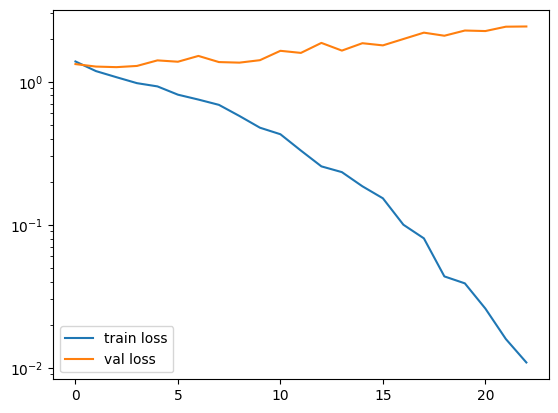

In [34]:
# plot the results
plt.plot(np.arange(len(res[0])), res[0], label='train loss')
plt.plot(np.arange(len(res[1])), res[1], label='val loss')
plt.yscale('log')
plt.legend()
plt.show()
plt.savefig('{}_losses_{}.png'.format("icp", "w2v"))

In [45]:
print("Starting testing")
test_res = trainer.test()

Starting testing
Test: loss: 4.444942275683085, accuracy: 42.604166666666664%, f-score: 0.4589094569255079


## With Weighted Loss Function

In [19]:
y_train.shape, y_val.shape, y_test.shape

((4520,), (1348,), (1512,))

In [20]:
y = np.hstack((y_train, y_val, y_test))
y.shape

(7380,)

In [21]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = t.tensor(class_weights, dtype=t.float)
 
print(class_weights)

tensor([0.8642, 0.9022, 1.3616, 0.7983, 1.3382])


In [49]:
#model = MLP(6144, 3000, 1000, 7)
model = MLP(3072, 1500, 500, 5)
#model = SimpleMLP()
print(model)

criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')

# set up the optimizer
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=0)

trainer = Trainer(model, "w2v", "icp", criterion, optimizer, train_loader, val_loader, test_loader, 
                  cuda=t.cuda.is_available(),\
                  early_stopping_patience=20)

# go, go, go... call fit on trainer
res = trainer.fit(EPOCHS)

MLP(
  (linear_1): Linear(in_features=3072, out_features=1500, bias=True)
  (linear_1_bn): BatchNorm1d(1500, eps=1e-05, momentum=0.6, affine=True, track_running_stats=True)
  (linear_2): Linear(in_features=1500, out_features=500, bias=True)
  (linear_2_bn): BatchNorm1d(500, eps=1e-05, momentum=0.6, affine=True, track_running_stats=True)
  (linear_out): Linear(in_features=500, out_features=5, bias=True)
)
Train: loss: 1.925300077653267
Validation: loss: 1.6888398690657183, accuracy: 33.80681818181818%, f-score: 0.37062549779885945
Validation loss decreased (inf --> 1.688840).  Saving model ...
Train: loss: 1.4294483712021733
Validation: loss: 1.5728402029384265, accuracy: 37.64204545454545%, f-score: 0.40838437823061985
Validation loss decreased (1.688840 --> 1.572840).  Saving model ...
Train: loss: 1.2329902665715822
Validation: loss: 1.5188372216441415, accuracy: 38.06818181818182%, f-score: 0.4121409557304011
Validation loss decreased (1.572840 --> 1.518837).  Saving model ...
Train

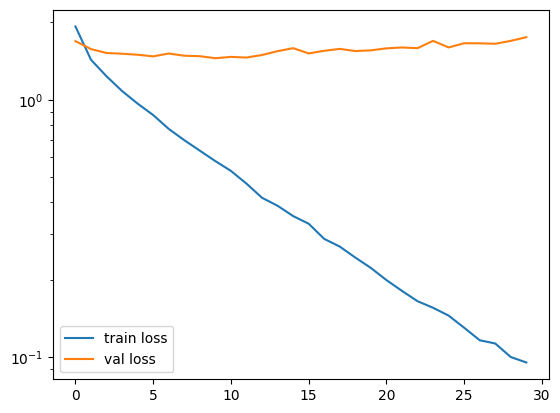

In [50]:
# plot the results
plt.plot(np.arange(len(res[0])), res[0], label='train loss')
plt.plot(np.arange(len(res[1])), res[1], label='val loss')
plt.yscale('log')
plt.legend()
plt.show()
plt.savefig('res/{}_losses_{}.png'.format("icp", "w2v"))

In [51]:
print("Starting testing")
test_res = trainer.test()

Starting testing
Test: loss: 1.7573806246121724, accuracy: 42.64322916666667%, f-score: 0.4652096251353786


In [52]:
test_res, pred = trainer.test()

Test: loss: 1.7573806246121724, accuracy: 42.64322916666667%, f-score: 0.4652096251353786


In [53]:
w2v_classes

[0, 1, 2, 3, 4]

In [54]:
print(classification_report(y_true=y_test, y_pred=pred, target_names=w2v_classnames))

              precision    recall  f1-score   support

         neu       0.38      0.31      0.34       258
         hap       0.35      0.45      0.39       303
         sad       0.61      0.50      0.55       143
         fru       0.45      0.37      0.41       481
         ang       0.47      0.56      0.51       327

    accuracy                           0.43      1512
   macro avg       0.45      0.44      0.44      1512
weighted avg       0.43      0.43      0.43      1512



## Confusion Matrix

In [55]:
#model_version = 'SimpleMLP'
model_version = 'MLP'

In [56]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix for ' + model_version,
                          cmap=plt.cm.RdPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     #   print("Normalized confusion matrix")
    #else:
     #   print('Confusion matrix, without normalization')
    
    #print(title)
    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('res/conf_matrix_{}.png'.format("icp"))
    plt.show()
    return cm
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs):
    #pred = np.argmax(pred_probs, axis=-1)
    #one_hot_true = one_hot_encoder(y_test, len(pred), len(CLASS_TO_ID))
    one_hot_true = one_hot_encoder(y_test, len(pred_probs), len(CLASS_TO_ID))
    acc = 'Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred_probs))
    fscore = 'Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred_probs, average='macro'))
    prec = 'Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred_probs, average='macro'))
    rec = 'Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred_probs, average='macro'))
    metrics = [acc, fscore, prec, rec]
    #if cm:
    cr = classification_report(y_true=y_test, y_pred=pred_probs, target_names=list(ID_TO_CLASS.values()))
    cm = plot_confusion_matrix(confusion_matrix(y_test, pred), classes=list(ID_TO_CLASS.values()))
    f = open('res/report_{}.txt'.format('icp'), 'w')
    f.write('RESULTS\n\nMetrics\n\n{}\n\nClassification Report\n\n{}\n\nConfusion Matrix\n\n{}\n'.format(metrics, cr, cm))
    f.close()
    print(cr)
    plot_confusion_matrix(confusion_matrix(y_test, pred), classes=list(ID_TO_CLASS.values()))

In [57]:
type(pred[0])

numpy.float64

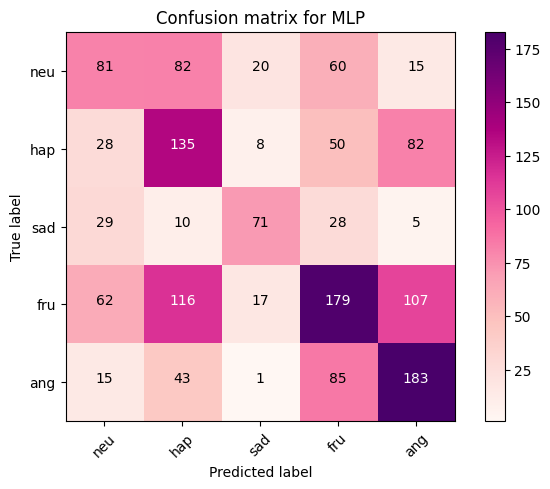

              precision    recall  f1-score   support

         neu       0.38      0.31      0.34       258
         hap       0.35      0.45      0.39       303
         sad       0.61      0.50      0.55       143
         fru       0.45      0.37      0.41       481
         ang       0.47      0.56      0.51       327

    accuracy                           0.43      1512
   macro avg       0.45      0.44      0.44      1512
weighted avg       0.43      0.43      0.43      1512



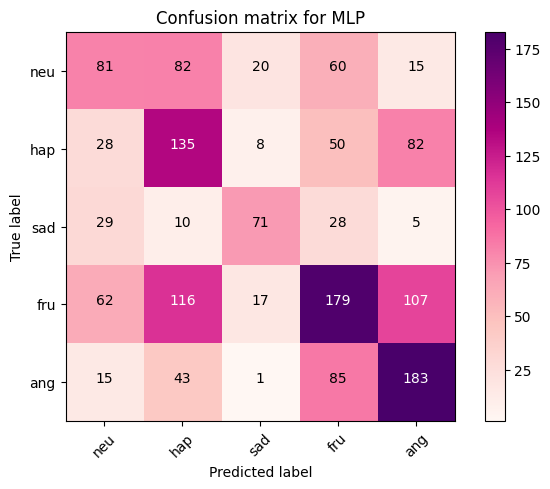

In [58]:
display_results(y_test, pred)

In [23]:
pred

array([4., 3., 4., ..., 2., 0., 2.])

In [25]:
y_test

array([3, 3, 3, ..., 2, 2, 1])

In [24]:
type(y_test), type(pred)

(numpy.ndarray, numpy.ndarray)

In [26]:
len(pred)

1512

In [31]:
pred_test = np.argmax(pred, axis=-1)

In [32]:
pred_test

0